# ENS491 - Reproducing and Analyzing Side Channel Attacks
## Loop-counting traces visualization and model training

Project Members:
- Barış Aytekin (barisaytekin@sabanciuniv.edu)
- Umut Eren Örnek (umuteren@sabanciuniv.edu)
- Ali Parlakçı (aliparlakci@sabanciuniv.edu)
- Doğukan Yıldırım (ydogukan@sabanciuniv.edu)
- Rana İşlek (ranaislek@sabanciuniv.edu)
- Ali Arda Girgin (agirgin@sabanciuniv.edu)
- Damla Sarıçelik (damlasaricelik@sabanciuniv.edu)

---

Import required packages.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import top_k_accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import trange

### Cases

> Before beginning testing different cases, let's begin with defining methods that will be used throughout this notebook.

Method to load all the trace data from `.pickle` files, and get traces and their respective labels as NumPy arrays:

In [26]:
def load_data(path: str):
    traces = []
    labels = []

    with open(path, "rb") as f:
        file_traces = pickle.load(f)

        for trace in file_traces:
            traces_i, labels_i = trace[0], trace[1]

            if isinstance(traces_i[0], list):
                traces.extend(traces_i)
            else:
                traces.append(traces_i)

            labels.append(labels_i)

        traces = np.array(traces)

        # Convert labels from domain names to ints
        domains = list(set(labels))
        int_mapping = {x: i for i, x in enumerate(domains)}
        labels = [int_mapping[x] for x in labels]
        labels = np.array(labels)

        return traces, labels, domains

Method to visualize traces:

In [27]:
def visualize_data(
    traces: np.array, 
    labels: np.array, 
    domains: list,
    domain_name: str,
    plot_title: str = "",
    num_traces_shown: int = 100
    ):
    
  df = pd.DataFrame()

  for i in range(0, len(traces)):
      df2 = pd.DataFrame(traces[i]).transpose()
      df2[domain_name] = domains[labels[i]]
      df = pd.concat([df,df2])

  df = df.groupby(domain_name).head(num_traces_shown)

  def heat(data,color):
      ax = sns.heatmap(data.drop([domain_name], axis=1), vmax=traces.max(), vmin=traces.min())
      ax.set(xticklabels=[round(i / 1000, 1) for i in ax.get_xticks()], yticklabels=[])
      ax.tick_params(left=False)
      
  fg = sns.FacetGrid(data=df, col=domain_name, aspect=3, height=2, col_wrap=2)
  fg.map_dataframe(heat)
  fg.fig.subplots_adjust(top=0.9)
  if plot_title:
      fg.fig.suptitle(plot_title)

`bigger-fish`'s default random forest classifier:

In [43]:
def print_random_forest_accuracies(
    traces: np.array, 
    labels: np.array, 
    domains: list,
    n = 10,
    test_size = 0.25
    
):
    def get_accuracies(X, y, domains):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y)

        clf = RandomForestClassifier()
        clf = clf.fit(X_train, y_train)

        y_probs = clf.predict_proba(X_test)
        top1 = top_k_accuracy_score(y_test, y_probs, k=1)
        top5 = top_k_accuracy_score(y_test, y_probs, k=5)

        return [top1, top5]

    accs = np.array([get_accuracies(traces, labels, domains) for _ in trange(n)])

    top1 = accs[:, 0].mean()
    top1_std = accs[:, 0].std()

    top5 = accs[:, 1].mean()
    top5_std = accs[:, 1].std()

    print(f"Number of traces: {len(traces)}")
    print("top1 accuracy: {:.1f}% (+/- {:.1f}%)".format(top1 * 100, top1_std * 100))
    print("top5 accuracy: {:.1f}% (+/- {:.1f}%)".format(top5 * 100, top5_std * 100))

#### Different codec, same video player

<blockquote>
Per codec:

- Number of runs: 100
- Trace length: 15 seconds
</blockquote>

##### Linux

In [44]:
traces, labels, domains = load_data(r'test_results/different_codec/traces_100_runs_15_sec_linux_OS.pkl')

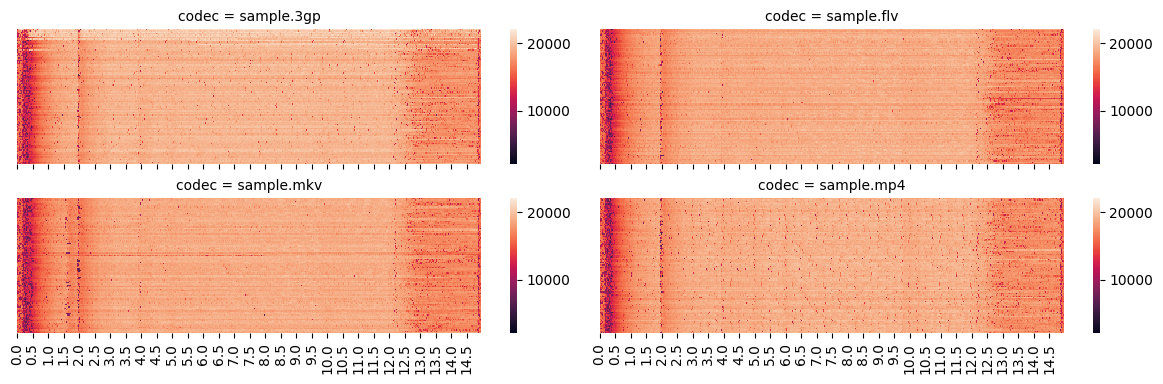

In [29]:
visualize_data(traces=traces, labels=labels, domains=domains, domain_name='codec', num_traces_shown=100)

In [45]:
print_random_forest_accuracies(traces=traces, labels=labels, domains=domains)

100%|██████████| 10/10 [00:12<00:00,  1.25s/it]

Number of traces: 400
top1 accuracy: 81.1% (+/- 2.4%)
top5 accuracy: 100.0% (+/- 0.0%)


#### Different video players, same codec

<blockquote>
Per codec:

- Number of runs: 100
- Trace length: 15 seconds
</blockquote>

##### Linux

In [46]:
traces, labels, domains = load_data(r'test_results/different_player/traces_100_runs_15_sec_linux_OS_player_asVar.pkl')

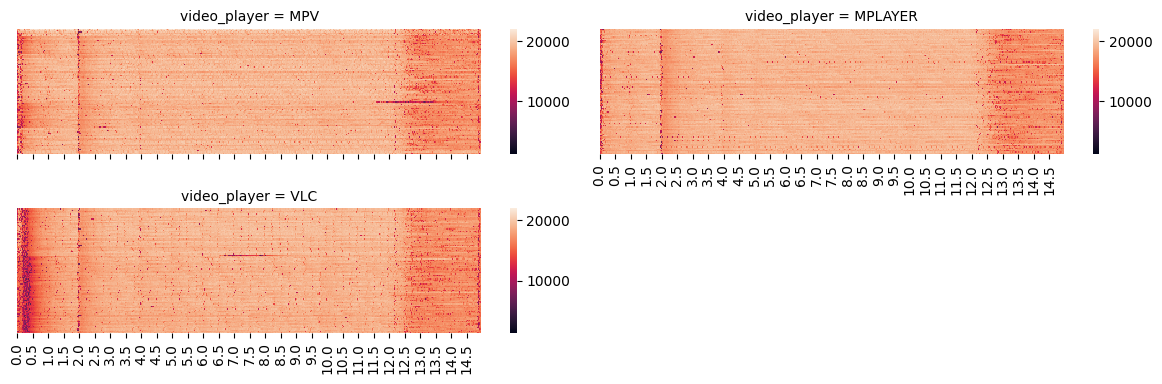

In [34]:
visualize_data(traces=traces, labels=labels, domains=domains, domain_name='video_player', num_traces_shown=100)

In [47]:
print_random_forest_accuracies(traces=traces, labels=labels, domains=domains)

100%|██████████| 10/10 [00:08<00:00,  1.17it/s]

Number of traces: 300
top1 accuracy: 91.9% (+/- 3.5%)
top5 accuracy: 100.0% (+/- 0.0%)
